<div style="background-color:#e8f4fd; padding:1em; border-radius:6px;">
<b>Notebook Disclaimer</b><br><br>
This notebook is part of the supporting material for the paper:<br>
<i>Modeling soil organic carbon changes using signal-to-noise analysis: a case study using European soil survey datasets.</i><br><br>
The figure and accompanying text are designed to be self-explanatory — you shouldn’t need to dive into the code to get the point :)<br>
But if you are curious about the implementation details, feel free to check the code blocks, too.
</div>

# SNR vs. RAE

This section presents an **exploratory analysis** of the relationship between the model’s **internal confidence (SNR)** and its **predictive accuracy (RAE)** in *SOC change modelling*.

Because the comparison is performed at the **point level**, summary metrics such as *R²* or *CCC* are not suitable — they condense the relationship into a single number and fail to capture point-wise variability.  
To account for the **scale of the change** in each target variable, we use the **Relative Absolute Error (RAE)** to evaluate prediction accuracy across all target variables ($c$, $\delta$, and $\beta$).  

The RAE is defined as the absolute difference between the predicted and observed values, normalized by the observed value.  
To avoid numerical instability when observed values are close to zero, a small constant (0.001) is added to the denominator:

$$
RAE = \frac{|\hat{y} - y|}{|y| + 0.001}
$$

where:
- $y$ = observed value (e.g., $\delta$ or $\beta$)  
- $\hat{y}$ = model prediction  

This formulation yields an **RAE per point**, analogous to the **SNR**, allowing a direct exploration of their relationship.


## state-first appraoch

In [1]:
##################
# basic settings #
##################

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
from sklearn.ensemble import RandomForestRegressor, IsolationForest
import joblib
import numpy as np
from scipy.stats import spearmanr

version = 'v20250521'
random_state = 42

###############################
# calculate snr and rae for c #
###############################

pnt = pd.read_parquet(f'./metric/point_predicted_{version}.pq')
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi'}

pnt = pnt.rename(columns = name_map)
for col in ['ndvi','ndwi']:
    pnt[col] = (pnt[col]-125)/125
    

pnt['snr'] = pnt['pred']/pnt['pred_std']
pnt['error'] = pnt['pred'] - pnt['soc']
pnt['abs_error'] = pnt['error'].abs()
pnt['signal'] = pnt['pred'].abs()
pnt['rae'] = pnt['abs_error']/pnt['soc']

####################################
# calculate snr and rae for \delta #
####################################

pair = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')
pair = pair.drop(columns=['time_pair_y','lc_survey_pair_x','pred_pair'])
pair = pair.rename(columns={'pred_change_pnt':'pred_pnt','pred':'pred_pair','pred_std':'noise_pair',
                            'time_pair_x':'time_pair','lc_survey_pair_y':'lc_survey_pair'})
pair['signal_pnt'] = pair['pred_pnt'].abs()
pair['signal_pair'] = pair['pred_pair'].abs()
pair['snr_pnt'] = pair['signal_pnt']/pair['noise_pnt']
pair['snr_pair'] = pair['signal_pair']/pair['noise_pair']
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]
pair['error'] = pair['pred_pnt'] - pair['soc_change']
pair['abs_error'] = pair['error'].abs()
pair['rae'] = pair['abs_error']/(pair['soc_change'].abs()+0.001)
# pair.loc[pair['soc_change'].abs()<1, 'rae'] =  pair.loc[pair['soc_change'].abs()<1, 'abs_error'] # "normalize" rae, with detectability floor == 1

###################################
# calculate snr and rae for \beta #
###################################

srs = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')
srs = srs[srs.columns[0:21].tolist()+srs.columns[-24::].tolist()]

srs = srs.rename(columns={'slope_pred':'pred_pnt', 'slope_std':'noise_pnt','pred':'pred_srs','pred_std':'noise_srs'})
srs['signal_pnt'] = srs['pred_pnt'].abs()
srs['signal_srs'] = srs['pred_srs'].abs()
srs['snr_pnt'] = srs['signal_pnt']/srs['noise_pnt']
srs['snr_srs'] = srs['signal_srs']/srs['noise_srs']
srs['error'] = srs['pred_pnt'] - srs['slope_obsv']
srs['rae'] = srs['error'].abs()/(srs['slope_obsv'].abs()+0.001)
srs['abs_error'] = srs['error'].abs()
# srs.loc[srs['slope_obsv'].abs()<0.5, 'rae'] =  srs.loc[srs['slope_obsv'].abs()<0.5, 'abs_error']/0.5

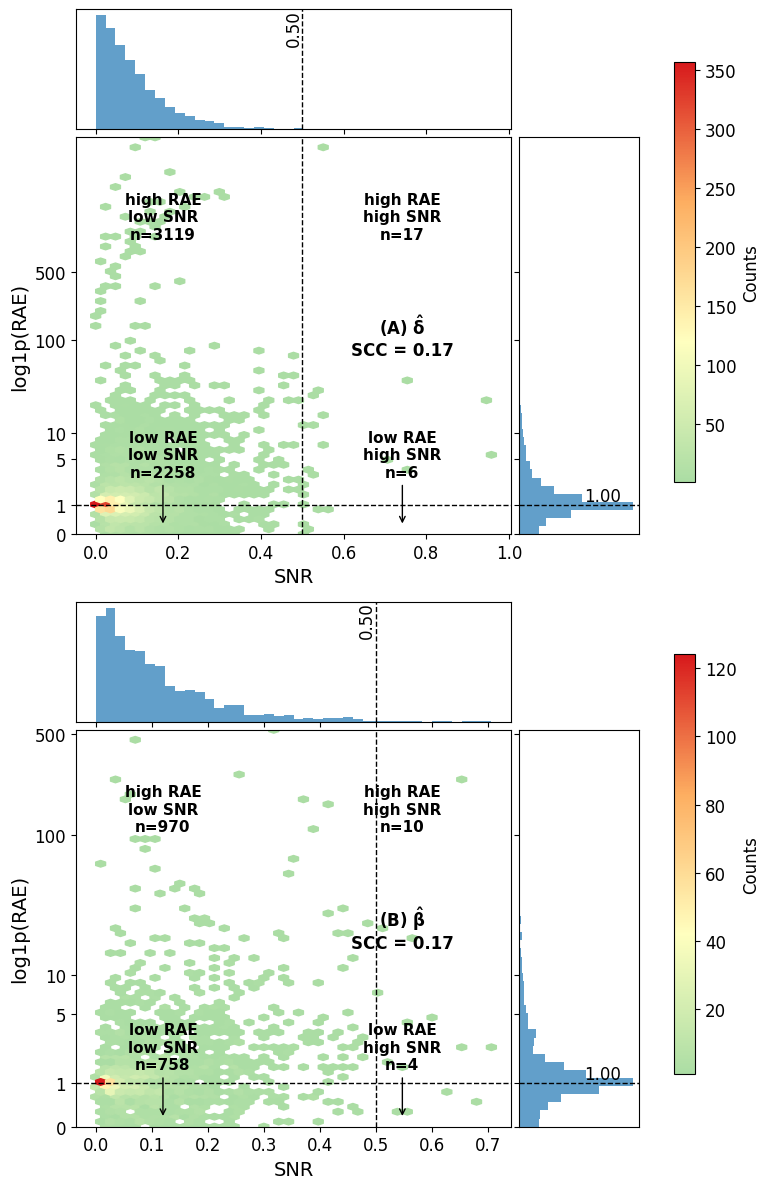

In [9]:
####################################
# plot snr vs. rae for state-first #
####################################

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable


# ──────────────────────────────────────────────────────────────────
# 1.  CONSTANTS
# -----------------------------------------------------------------
cmap_cet_l19 = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)
Q_SNR, Q_RAE = 0.5, 1.0          # vertical & horizontal cut-offs (orig. units)
Y_TICKS_ORIG = np.array([0, 1, 5, 10, 100, 500])  # labels you want to show
Y_TICKS_PLOT = np.log1p(Y_TICKS_ORIG)             # where they sit after log1p
YTICK_LABELS = [str(v) for v in Y_TICKS_ORIG]

# ──────────────────────────────────────────────────────────────────
# 2.  SMALL HELPER FUNCTION  – draws ONE panel on supplied axes
# -----------------------------------------------------------------
def joint_hex_panel(ax_main, data, snr_col, panel_code, metric_text,
                    cmap=cmap_cet_l19, gridsize=(40, 40)):
    """Draw joint hex-bin + marginal histograms on ax_main & its twin axes."""
    # ----- create marginal axes
    divider   = make_axes_locatable(ax_main)
    ax_top    = divider.append_axes("top",   1.2, pad=0.08, sharex=ax_main)
    ax_right  = divider.append_axes("right", 1.2, pad=0.08, sharey=ax_main)

    plt.setp(ax_top.get_xticklabels(),   visible=False)
    plt.setp(ax_right.get_yticklabels(), visible=False)

    # ----- log1p-transform only for plotting geom
    y_log = np.log1p(data["rae"])
    q_rae_plot = np.log1p(Q_RAE)

    # ----- main hex-bin
    hb = ax_main.hexbin(
        data[snr_col], y_log,
        gridsize=gridsize, cmap=cmap, mincnt=1,
    )
    ax_main.axvline(Q_SNR,      ls="--", lw=1, c="k")
    ax_main.axhline(q_rae_plot, ls="--", lw=1, c="k")
    # ax_main.set_xlim(0, 1)
    ax_main.set_ylim(y_log.min(), y_log.max())
    ax_main.set_xlabel("SNR", fontsize=14)
    ax_main.set_ylabel("log1p(RAE)", fontsize=14)
    ax_main.set_yticks(Y_TICKS_PLOT)
    ax_main.set_yticklabels(YTICK_LABELS, fontsize=12)
    ax_main.tick_params(axis='x', which='major', labelsize=12)

    cbar = ax_main.figure.colorbar(
        hb, ax=ax_main, shrink=0.8, label="Counts"
    )
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("Counts", fontsize=12)

    # ----- top histogram
    ax_top.hist(
        data[snr_col], bins=40, density=True,
        histtype="stepfilled", alpha=0.7,
    )
    ax_top.axvline(Q_SNR, ls="--", lw=1, c="k")
    ax_top.text(
        Q_SNR, ax_top.get_ylim()[1]*0.85, f"{Q_SNR:.2f}",
        ha="right", va="center", rotation=90, fontsize=12
    )
    ax_top.yaxis.set_visible(False)

    # ----- right histogram
    ax_right.hist(
        y_log, bins=np.linspace(y_log.min(), y_log.max(), 50),
        orientation="horizontal", density=True,
        histtype="stepfilled", alpha=0.7
    )
    ax_right.axhline(q_rae_plot, ls="--", lw=1, c="k")
    ax_right.text(
        ax_right.get_xlim()[1]*0.85, q_rae_plot,
        f"{Q_RAE:.2f}", ha="right", va="bottom", fontsize=12
    )
    ax_right.set_yticks(Y_TICKS_PLOT)
    ax_right.set_yticklabels(YTICK_LABELS, fontsize=12)
    ax_right.xaxis.set_visible(False)

    # ----- quadrant counts on *original* scale
    hi_snr = data[snr_col] >= Q_SNR
    hi_rae = data["rae"]     >= Q_RAE
    lo_snr = ~hi_snr
    lo_rae = ~hi_rae
    counts = {
        "HH": (hi_rae & hi_snr).sum(),
        "HL": (hi_rae & lo_snr).sum(),
        "LH": (lo_rae & hi_snr).sum(),
        "LL": (lo_rae & lo_snr).sum(),
    }
    ax_main.text(0.75, 0.80, f"high RAE\nhigh SNR\nn={counts['HH']}",
                 transform=ax_main.transAxes, ha="center", va="center",
                 weight="bold", fontsize=11)
    ax_main.text(0.2, 0.80, f"high RAE\nlow SNR\nn={counts['HL']}",
                 transform=ax_main.transAxes, ha="center", va="center",
                 weight="bold", fontsize=11)
    ax_main.text(0.75, 0.20, f"low RAE\nhigh SNR\nn={counts['LH']}",
                 transform=ax_main.transAxes, ha="center", va="center",
                 weight="bold", fontsize=11)
    ax_main.annotate("", xy=(0.75, 0.02), xytext=(0.75, 0.13),
                     xycoords="axes fraction", textcoords="axes fraction",
                     arrowprops=dict(arrowstyle="->", lw=1))
    ax_main.text(0.2, 0.20, f"low RAE\nlow SNR\nn={counts['LL']}",
                 transform=ax_main.transAxes, ha="center", va="center",
                 weight="bold", fontsize=11)
    ax_main.annotate("", xy=(0.2, 0.02), xytext=(0.2, 0.13),
                     xycoords="axes fraction", textcoords="axes fraction",
                     arrowprops=dict(arrowstyle="->", lw=1))

    # ----- panel label
    corr, p_value = spearmanr(data['rae'], data[snr_col])
    ax_main.text(
        0.75, 0.50,
        rf"({panel_code}) $\mathbf{{{metric_text}}}$" + "\n" + f"SCC = {corr:.2f}",
        transform=ax_main.transAxes, ha="center", va="center",
        fontsize=12, fontweight="bold"
    )

    # ──────────────────────────────────────────────────────────────────
# 3.  CREATE THE 2×1 FIGURE  &  DRAW BOTH PANELS
# -----------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 12), sharex=False, sharey=False
)

joint_hex_panel(axes[0], pair, 'snr_pnt', "A", r"\hat{\delta}")
joint_hex_panel(axes[1], srs, 'snr_pnt', "B", r"\hat{\beta}")

plt.tight_layout()
# plt.savefig("./figure/plot_compare_snr.rae.pdf", bbox_inches="tight")
plt.show()


### Plot description

Density plots of RAE versus SNR for both $\hat{\delta}$ (A) and $\hat{\beta}$ (B), quantified using the **state-first** bapproach. 

RAE is shown on a $\log_{1p}$ scale to enhance visibility of lower values. Each plot is divided into four quadrants using thresholds of RAE = 1 and SNR = 0.5, representing: high RAE and low SNR, high RAE and high SNR, low RAE and low SNR, and low RAE and high SNR. 

Marginal distributions, the distribution of individual variables without conditioning on others, are displayed along the top and right axes. The Spearman correlation coefficient (SCC) between RAE and SNR is indicated in each plot.

### Results analysis

The Spearman correlation coefficient (SCC) was used to assess the relationship between SNR and RAE. As a rank-based measure of monotonic association, values closer to 1 or –1 indicate stronger positive or negative relationships, respectively. 

This shows that predictions with high SNR do not necessarily exhibit higher accuracy for either $\hat{\delta}$ (SCC = 0.17) or $\hat{\beta}$ (SCC = 0.17), indicating only a weak positive correlation between SNR and RAE. 

For both targets, the SNR is usually below one while the RAE centers around one. The majority of predictions fall into the "high RAE and low SNR" quadrant, followed by "low RAE and low SNR", "high RAE and high SNR", and lastly "low RAE and high SNR". 

## change-first approach

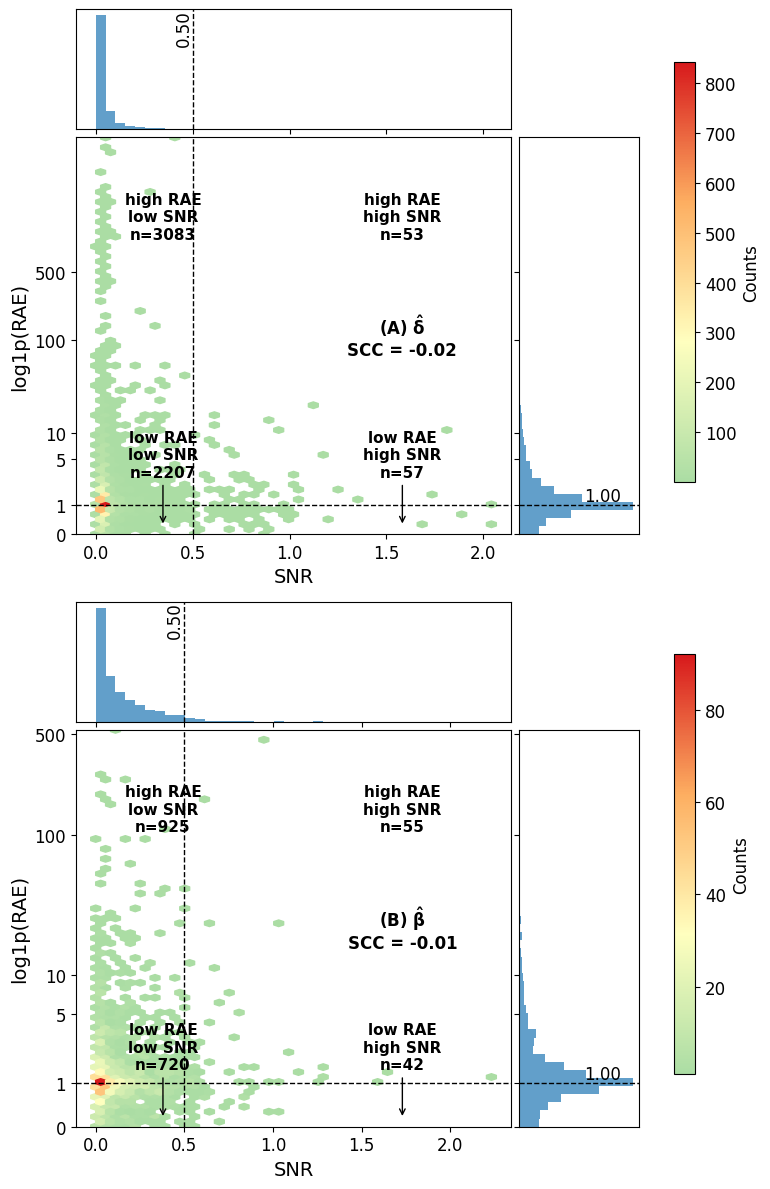

In [10]:
#####################################
# plot snr vs. rae for change-first #
#####################################

fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 12), sharex=False, sharey=False
)

joint_hex_panel(axes[0], pair, 'snr_pair', "A", r"\hat{\delta}")
joint_hex_panel(axes[1], srs, 'snr_srs', "B", r"\hat{\beta}")

plt.tight_layout()
# plt.savefig("./figure/plot_compare_snr.rae.pdf", bbox_inches="tight")
plt.show()

### Plot Description

Density plots of **RAE** versus **SNR** for both $\hat{\delta}$ (A) and $\hat{\beta}$ (B) are shown below, quantified using the **change-first** approach.

### Results Analysis

A similar pattern to the **state-first** approach is observed: most points exhibit **SNR values close to zero**, while **RAE values cluster around 1.7** (i.e., `log1p(RAE)` ≈ 1). This indicates **poor predictive accuracy** and **low detectability/confidence** in the SOC change modeling.

Compared to the state-first approach, the **Spearman correlation coefficient (SCC)** between SNR and RAE in the change-first approach is even weaker, with $\hat{\delta}$: **SCC = -0.02** and $\hat{\beta}$: **SCC = -0.01**.

indicating **almost no monotonic relationship** between SNR and RAE.



## Extra: Explorative Correlation Analysis

From the analysis above, we observed only a **moderate to minimal relationship** between **SNR** (change modeling confidence) and **RAE** (change prediction accuracy). In particular, for the **change-first** approach, the **Spearman correlation coefficient (SCC)** is nearly zero.

To further investigate, this section conducts an additional exploratory analysis to examine whether **SNR** shows any notable relationship with other variables under the **change-first** approach.  

Apart from **SNR** and **RAE**, the additional variables (or metrics) considered include:

- **SOC** – to examine the relationship between SOC level and SOC change detectability.  
  (Averaged across time steps if changes are present.)
- **NDVI** – to examine the relationship between vegetation content and SOC change detectability.
- **Anomaly** – to examine the relationship between extrapolation likelihood and SOC change detectability.  
  Derived using an *Isolation Forest*, based on the similarity of test samples to the feature space of the training data.  
  Higher values indicate more anomalous samples, which are more likely to be extrapolations.


Apart from $\hat{\delta}$ and $\hat{\beta}$, the examination is also performed at the **point level** on $\hat{c}$.


/tmp/ipykernel_876359/3189899910.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


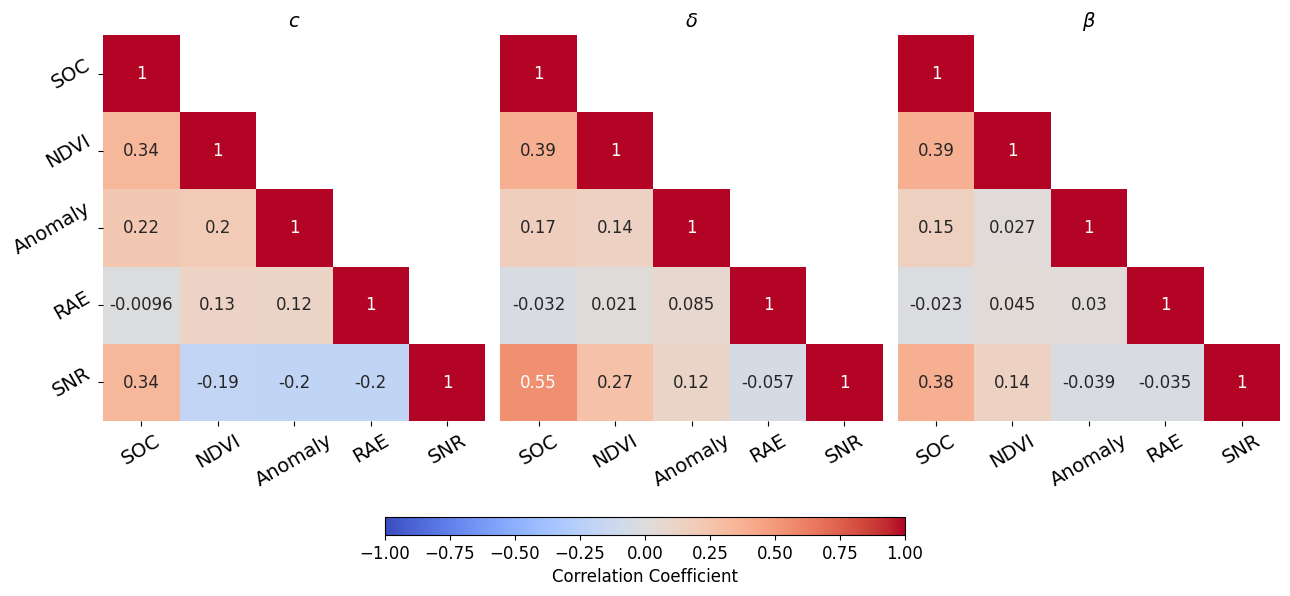

In [11]:
###########################################
# calculation of correlation for variables#
###########################################


#############
# point - c #
#############

# params
prop = 'slope'
tgt = 'ts_slope'
space = 'normal'

# covs
covs = pd.read_csv(f'./metric/feature_selected_{prop}_{version}.txt', header=None)[0].tolist() 
# train data
train = pd.read_parquet(f'./material/srs_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
# test
srs = pd.read_parquet(f'./metric/srs_predicted.srs_{version}.pq')
# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(srs[covs])
srs['Anomaly'] = isof.decision_function(srs[covs]) # inlier -> 0, outlier -> -1
srs['Anomaly'] = srs['Anomaly']*(-1) # inlier -> 0, outlier -> 1, the higher the score is, the more abnormal it is

srs['signal'] = srs['ts_slope'].abs()
srs = srs.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_mean':'NDVI','pred_std':'noise_srs'})
srs['SNR'] = srs['signal']/srs['noise_srs']
srs['SOC'] = srs['soc_series'].apply(lambda x: np.mean(x))

srs['error'] = srs['pred'] - srs[tgt]
srs[r'RAE'] = srs['error'].abs()/srs['signal'] #$Error_{\mathrm{abs}}$

coe_srs = srs[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()


#################
# pair - \delta #
#################

# params
prop = 'change'
tgt = 'soc_change'
space = 'normal'

# covs
covs = pd.read_csv(f'./metric/feature_selected_{prop}_{version}.txt', header=None)[0].tolist() 
# train data
train = pd.read_parquet(f'./material/pair_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
# test
pair = pd.read_parquet(f'./metric/pair_predicted.pair_{version}.pq')
# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(pair[covs])
pair['Anomaly'] = isof.decision_function(pair[covs]) 
pair['Anomaly'] = pair['Anomaly']*(-1) 

pair = pair.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_mean':'NDVI','pred_std':'noise_pair','soc_mean':'SOC'})
pair['signal'] = pair['soc_change'].abs()
pair['SNR'] = pair['signal']/pair['noise_pair']

pair['error'] = pair['pred'] - pair[tgt]
pair[r'RAE'] = pair['error'].abs()/pair['signal']

coe_pair = pair[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()


##################
# series - \beta #
##################

prop = 'soc'
tgt = 'soc_log1p'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/pnt_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test = pd.read_parquet(f'./metric/point_predicted_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)

# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(test[covs])
test['Anomaly'] = isof.decision_function(test[covs]) 
test['Anomaly'] = test['Anomaly']*(-1) 

test = test.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'NDVI','soc':'SOC'})
test['SNR'] = test['SOC']/test['pred_std']
test['error'] = test['pred'] - test['SOC']
test[r'RAE'] = test['error'].abs()/test['SOC']

coe_pnt = test[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()


#########
# plot #
#########

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

titles = [r'$c$', r'$\delta$', r'$\beta$']
matrices = [coe_pnt, coe_pair, coe_srs]
mask = np.triu(np.ones_like(coe_pnt, dtype=bool),k=1)

fig, axes = plt.subplots(1, 3, figsize=(13, 6))

vmin, vmax = -1, 1

for i, (ax, matrix, title) in enumerate(zip(axes, matrices, titles)):
    sns.heatmap(
        matrix,
        ax=ax,
        mask=mask,
        cmap="coolwarm",
        annot=True,
        vmin=vmin,
        vmax=vmax,
        center=0,
        cbar=False,
        annot_kws={"size": 12},
        yticklabels=(i == 0),  # Show y-tick labels only on the first plot
        # linewidths=0.5,
        # linecolor='black'
    )
    ax.set_title(title.capitalize(), fontsize=14)
    ax.tick_params(axis='x', rotation=30,labelsize=14)
    ax.tick_params(axis='y', rotation=30,labelsize=14)

cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Correlation Coefficient", fontsize=12)

plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig(f'./figure/plot_corr_metrics.pdf', bbox_inches='tight')
plt.show()


In general, no clear relationship is observed between SNR and the additional variables examined here.

Among them, **SOC shows the most noticeable positive relationship with SNR** (0.34 for $c$; 0.55 for $\delta$; and 0.38 for $\beta$), suggesting that it is more probable to model SOC change effectively at points with larger baseline SOC values. **NDVI typically exhibits the second most evident relationship with SNR**.

For $\hat{c}$ (SOC level) modeling, NDVI shows a negative relationship with SNR (-0.19), indicating that higher vegetation content may increase model uncertainty and reduce confidence. However, for change modeling — i.e., $\hat{\delta}$ and $\hat{\beta}$ — NDVI shows a positive relationship with SNR (0.27 for $\delta$; and 0.14 for $\beta$). 

This aligns with the earlier finding that SNR tends to be slightly higher in woodland and grassland areas, which generally correspond to higher SOC and NDVI values.

The remaining variables exhibit weak correlations with SNR (|SCC| < 0.2). An exception is observed for $\hat{c}$ modeling, where a moderate negative relationship appears between SNR and both Anomaly and RAE.

